In [15]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Concatenate, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

In [16]:
token = 'all_captions/Flickr8k.token.txt'

In [17]:
captions = open(token, 'r').read().strip().split('\n')

In [18]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [19]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [29]:
images = "all_images/Flicker8k_Dataset/"
images

'all_images/Flicker8k_Dataset/'

In [34]:
# Contains all the images
img = glob.glob(images+'*.jpg')
img[:2]

['all_images/Flicker8k_Dataset/2387197355_237f6f41ee.jpg',
 'all_images/Flicker8k_Dataset/2609847254_0ec40c1cce.jpg']

In [35]:
train_images_file = 'all_captions/Flickr_8k.trainImages.txt'

In [36]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [37]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [38]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [39]:
val_images_file = 'all_captions/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [40]:
test_images_file = 'all_captions/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

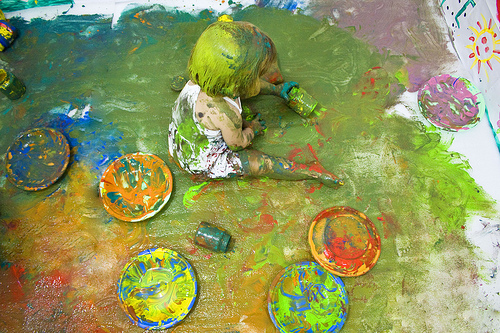

In [42]:
Image.open(train_img[8])

In [43]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


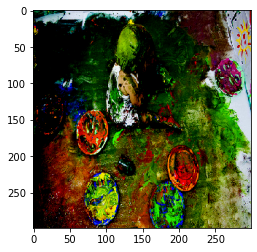

In [44]:
plt.imshow(np.squeeze(preprocess(train_img[8])))

In [45]:
model = InceptionV3(weights='imagenet')

In [46]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [47]:
tryi = model_new.predict(preprocess(train_img[8]))

In [48]:
tryi.shape

(1, 2048)

In [49]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [50]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████| 6000/6000 [09:29<00:00, 10.53it/s]


In [51]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [52]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [53]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [54]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [01:43<00:00,  9.68it/s]


In [55]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [56]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [57]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [58]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

len(train_d)

6000

In [59]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [60]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]
        
len(val_d)

1000

In [61]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

len(test_d)

1000

In [62]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')
        
words = [i.split() for i in caps]

unique = []
for i in words:
    unique.extend(i)

In [63]:
unique = list(set(unique))

In [65]:
with open("unique.p", "wb") as pickle_d:
    pickle.dump(unique, pickle_d)

In [66]:
unique = pickle.load(open('unique.p', 'rb'))
len(unique)

8256

In [68]:
word2idx = {val:index for index, val in enumerate(unique)}
word2idx['<start>']

4825

In [69]:
idx2word = {index:val for index, val in enumerate(unique)}
idx2word[4825]

'<start>'

In [70]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [71]:
len(unique), max_len

(8256, 40)

In [73]:
vocab_size = len(unique)
vocab_size

8256

In [74]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [75]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [76]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [77]:
len(df)


30000

In [78]:
c = [i for i in df['captions']]
len(c)

30000

In [79]:
imgs = [i for i in df['image_id']]

In [80]:
a = c[-1]
a, imgs[-1]

('<start> A longeared dog running in the grass . <end>',
 '2764732789_1392e962d0.jpg')

In [81]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 4825
A => 6604
longeared => 6188
dog => 917
running => 4677
in => 7489
the => 6313
grass => 6564
. => 3493
<end> => 1446


In [82]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [141]:
samples_per_epoch

383454

In [142]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [134]:
def data_generator(batch_size = 32):
    partial_caps = []
    next_words = []
    images = []
        
    df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
    df = df.sample(frac=1)
    iter = df.iterrows()
    
    c = []
    imgs = []
    for i in range(df.shape[0]):
        x = next(iter)
        c.append(x[1][1])
        imgs.append(x[1][0])

    count = 0
    while True:
        for j, text in enumerate(c):
            current_image = encoding_train[imgs[j]]
            for i in range(len(text.split())-1):
                count+=1
                
                partial = [word2idx[txt] for txt in text.split()[:i+1]]
                partial_caps.append(partial)
                    
                # Initializing with zeros to create a one-hot encoding matrix
                # This is what we have to predict
                # Hence initializing it with vocab_size length
                n = np.zeros(vocab_size)
                # Setting the next word to 1 in the one-hot encoded matrix
                n[word2idx[text.split()[i+1]]] = 1
                next_words.append(n)
                    
                images.append(current_image)
                
                if count>=batch_size:
                    next_words = np.asarray(next_words)
                    images = np.asarray(images)
                    partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                    yield [[images, partial_caps], next_words]
                    partial_caps = []
                    next_words = []
                    images = []
                    count = 0

In [155]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers.merge import add
from keras.layers.embeddings import Embedding

In [157]:
embedding_size = 300
max_length=40

In [156]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

NameError: name 'max_length' is not defined

In [144]:
# Input dimension is 4096 since we will feed it the encoded version of the image.
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

In [145]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

In [146]:
from keras.layers.merge import Concatenate, Average   

In [147]:
final_model = Sequential([
        Concatenate([image_model, caption_model]),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

In [148]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [149]:
#final_model.summary()

In [150]:
train_generator = data_generator(batch_size=128)

TypeError: data_generator() got an unexpected keyword argument 'batch_size'

In [152]:
final_model.fit(data_generator, steps_per_epoch=samples_per_epoch, epochs=1, 
                          verbose=2)

ValueError: Failed to find data adapter that can handle input: <class 'function'>, <class 'NoneType'>

In [140]:
final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch, epochs=1, 
                          verbose=2)

Consider rewriting this model with the Functional API.


TypeError: in user code:

    /Users/indupriyakompi/opt/anaconda3/envs/dlvirenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/indupriyakompi/opt/anaconda3/envs/dlvirenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/indupriyakompi/opt/anaconda3/envs/dlvirenv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/indupriyakompi/opt/anaconda3/envs/dlvirenv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/indupriyakompi/opt/anaconda3/envs/dlvirenv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/indupriyakompi/opt/anaconda3/envs/dlvirenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/indupriyakompi/opt/anaconda3/envs/dlvirenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/indupriyakompi/opt/anaconda3/envs/dlvirenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/indupriyakompi/opt/anaconda3/envs/dlvirenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:389 call
        outputs = layer(inputs, **kwargs)
    /Users/indupriyakompi/opt/anaconda3/envs/dlvirenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1008 __call__
        self._maybe_build(inputs)
    /Users/indupriyakompi/opt/anaconda3/envs/dlvirenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2710 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    /Users/indupriyakompi/opt/anaconda3/envs/dlvirenv/lib/python3.8/site-packages/tensorflow/python/keras/utils/tf_utils.py:272 wrapper
        output_shape = fn(instance, input_shape)
    /Users/indupriyakompi/opt/anaconda3/envs/dlvirenv/lib/python3.8/site-packages/tensorflow/python/keras/layers/merge.py:500 build
        del reduced_inputs_shapes[i][self.axis]

    TypeError: list indices must be integers or slices, not ListWrapper
